# BARRA/ERA5 climatology

In [168]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
sys.path.append('/g/data/qz03/wp3/code/git-repo')
from utils import *

In [2]:
import warnings
import logging
warnings.filterwarnings('ignore') 
logging.getLogger("distributed.worker.memory").setLevel(logging.ERROR)
logging.getLogger('flox').setLevel(logging.WARNING)

In [3]:
import dask
import tempfile
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

dask.config.set({
    'array.chunk-size': "256 MiB",
    'array.slicing.split_large_chunks': True, #This can make AXIOM very slow
    'distributed.comm.timeouts.connect': '120s',
    'distributed.comm.timeouts.tcp': '120s',
    'distributed.comm.retry.count': 10,
    'distributed.scheduler.allowed-failures': 20,
    "distributed.scheduler.worker-saturation": 1.1, #This should use the new behaviour which helps with memory pile up
})

# client = dask.distributed.Client()
client = Client(n_workers=10, threads_per_worker=1, local_directory = tempfile.mkdtemp(), memory_limit = "63000mb")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 586.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37167,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 586.73 GiB
Comm: tcp://127.0.0.1:42167,Total threads: 1
Dashboard: /proxy/39077/status,Memory: 58.67 GiB
Nanny: tcp://127.0.0.1:37405,


2025-05-14 12:07:07,369 - distributed.nanny - WARNING - Restarting worker
2025-05-14 12:07:07,545 - distributed.nanny - WARNING - Restarting worker
2025-05-14 12:07:07,547 - distributed.nanny - WARNING - Restarting worker
2025-05-14 12:07:07,553 - distributed.nanny - WARNING - Restarting worker
2025-05-14 12:07:07,581 - distributed.nanny - WARNING - Restarting worker
2025-05-14 12:07:07,587 - distributed.nanny - WARNING - Restarting worker
2025-05-14 12:07:07,592 - distributed.nanny - WARNING - Restarting worker
2025-05-14 12:07:07,597 - distributed.nanny - WARNING - Restarting worker
2025-05-14 12:07:07,608 - distributed.nanny - WARNING - Restarting worker
2025-05-14 12:07:08,338 - distributed.nanny - WARNING - Restarting worker


In [4]:
%%time
barra_winds_dly = xr.open_mfdataset(glob.glob('/g/data/qz03/wp3/data/BARRAR2/day/sfcWind/*.nc'),combine='nested', concat_dim='time',parallel=True, engine='netcdf4').chunk({'time':-1, 'lat':'auto', 'lon':'auto'}).compute()

CPU times: user 12.1 s, sys: 7.15 s, total: 19.3 s
Wall time: 38.1 s


In [6]:
%%time
barra_winds_monthly = (barra_winds_dly.groupby('time.month'))
dry_season_winds = barra_winds_dly.sel(time=barra_winds_dly.time.dt.month.isin([5, 6, 7, 8, 9])).mean('time')
wet_season_winds = barra_winds_dly.sel(time=barra_winds_dly.time.dt.month.isin([10, 11, 12, 1, 2, 3, 4])).mean('time')
annual_winds = barra_winds_dly.groupby('time.year').mean('time').mean('year')

CPU times: user 56.2 s, sys: 1min 41s, total: 2min 37s
Wall time: 2min 9s


In [93]:
def plot_climo(plot_type, input_climo_xr, plot_var, cmap, vmin, vmax, cbar_extend, cbar_label, plot_title):
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    sys.path.append('/g/data/qz03/wp3/code/git-repo')
    from utils import domain_dict
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    plot_array = input_climo_xr[plot_var]
    
    contour = plot_array.plot.imshow(ax=ax, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False) if plot_type =='raster' else plot_array.plot.contourf(ax=ax, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), cmap=cmap, levels=((vmax-vmin)*2)+1, add_colorbar=False)
    cbar = fig.colorbar(contour, ax=ax, orientation='horizontal', pad=0.05, fraction=0.07, shrink=0.6, extend=cbar_extend, label=cbar_label)
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(plot_title, fontsize=14, pad=12)
    ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'], domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())
    
    plt.tight_layout()
    plt.show()
    return

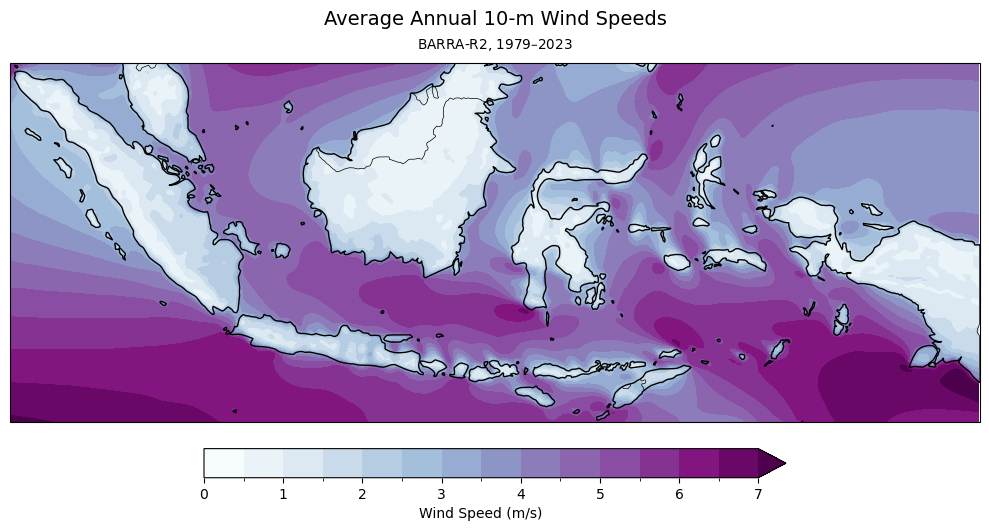

In [97]:
plot_climo('contour', annual_winds, 'sfcWind', 'BuPu', 0, 7, 'max', 'Wind Speed (m/s)', 'Average Annual 10-m Wind Speeds\n$_{\\text{BARRA-R2, 1979–2023}}$')

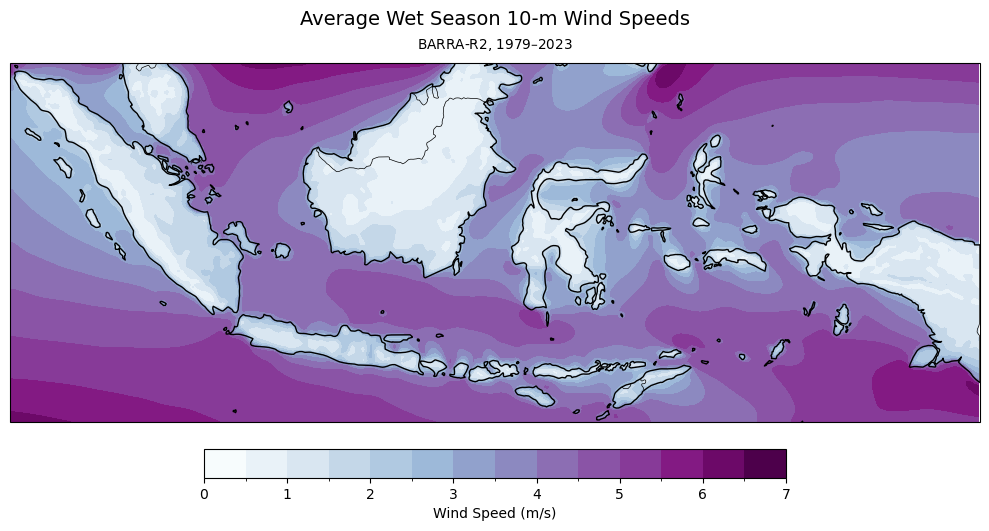

In [100]:
plot_climo('contour', wet_season_winds, 'sfcWind', 'BuPu', 0, 7, 'max', 'Wind Speed (m/s)', 'Average Wet Season 10-m Wind Speeds\n$_{\\text{BARRA-R2, 1979–2023}}$')

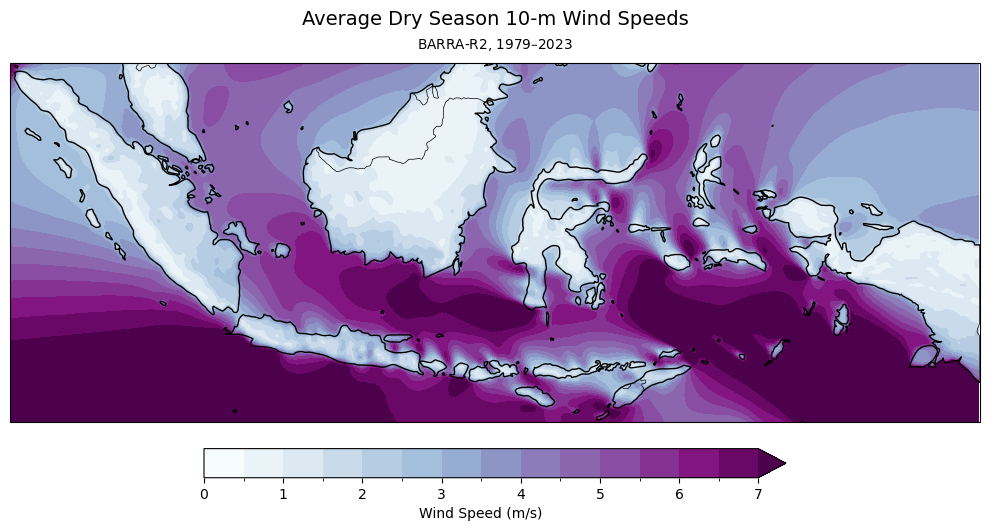

In [101]:
plot_climo('contour', dry_season_winds, 'sfcWind', 'BuPu', 0, 7, 'max', 'Wind Speed (m/s)', 'Average Dry Season 10-m Wind Speeds\n$_{\\text{BARRA-R2, 1979–2023}}$')

In [140]:
loc_data = barra_winds_dly.sel(lat=-5.645031, lon=119.711252, method='nearest').sortby('time')

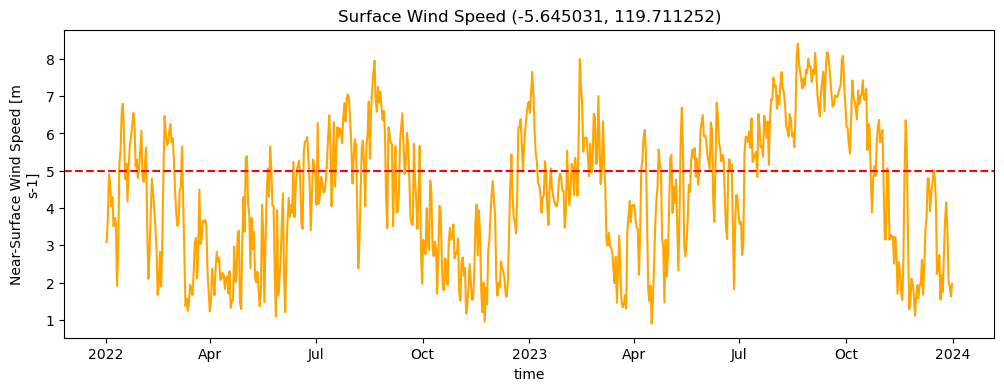

In [163]:
ax = loc_data.sel(time=slice('2022-01-01', '2024-01-01')).sfcWind.plot.line(color='orange', figsize=(12, 4))
plt.title('Surface Wind Speed (-5.645031, 119.711252)')
plt.axhline(y=5, color='red', linestyle='--')
plt.show()

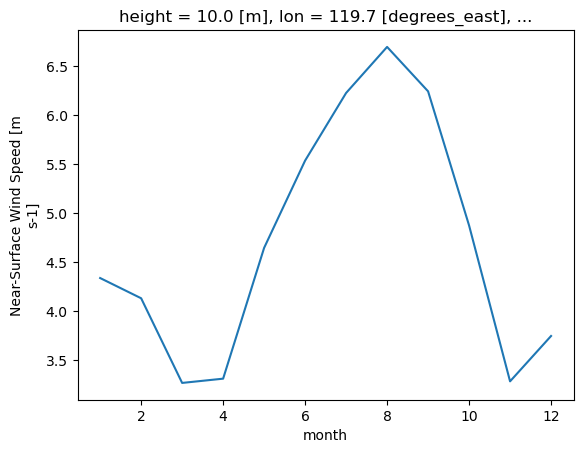

In [134]:
monthly_data = loc_data.groupby('time.month').mean()
monthly_data.sfcWind.plot()

In [182]:
def read_nino(
    url="http://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.91-20.ascii",
    ):
    """
    Read NINO data from specified web URL - assumes NOAA CPC formatting
     - old url was "http://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.81-10.ascii"
    """
    #Skip header - we will specify our own
    columns=['year','month','nino1+2','nino1+2 anom','nino3','nino3 anom','nino4','nino4 anom','nino3.4','nino3.4 anom']
    nino_data = pd.read_csv(url,skiprows=1,names=columns,delim_whitespace=True)
    #output nino3.4 anomalies in required format
    nino_data['time'] =  pd.to_datetime((nino_data['year'].map(str)+nino_data['month'].map(str)),format='%Y%m')
    nino_data.set_index('time',inplace=True)
    # remove superfluous year, month columns
    nino_data.drop(['year','month'],axis='columns',inplace=True)
    nino_data.sort_index(inplace=True)

    for column in [
        'nino1+2', 'nino1+2 anom',
        'nino3', 'nino3 anom',
        'nino4', 'nino4 anom',
        'nino3.4', 'nino3.4 anom',
        ]:
        # take 3m rolling mean as new column (column index = 2, doesn't matter)
        nino_data.insert(2,column+' 3m mean', nino_data[column].rolling(window=3).mean(), allow_duplicates=True)

    return nino_data


In [183]:
nino_df = read_nino()

In [184]:
nino_df['nino3.4 anom']

time
1950-01-01   -1.99
1950-02-01   -1.69
1950-03-01   -1.42
1950-04-01   -1.54
1950-05-01   -1.75
              ... 
2024-12-01   -0.60
2025-01-01   -0.74
2025-02-01   -0.43
2025-03-01    0.01
2025-04-01   -0.16
Name: nino3.4 anom, Length: 904, dtype: float64

In [211]:
nino_df['phase'] = nino_df['nino3.4 anom'].apply(lambda x: 1 if x >= 0.8 else (-1 if x <= -0.8 else 0)) # 1 el nino # -1 la nina # 0 neutral

In [212]:
nino_df['phase'] 

time
1950-01-01   -1
1950-02-01   -1
1950-03-01   -1
1950-04-01   -1
1950-05-01   -1
             ..
2024-12-01    0
2025-01-01    0
2025-02-01    0
2025-03-01    0
2025-04-01    0
Name: phase, Length: 904, dtype: int64

In [239]:
enso_phase = xr.DataArray(data=nino_df['phase'].values, coords={'time': nino_df.index}, dims='time', name='enso')

In [242]:
barra_winds_mth = barra_winds_dly.sortby('time').resample(time='1MS').mean()

In [292]:
barra_winds_mth_anom = barra_winds_mth - barra_winds_mth.mean(dim='time')

In [293]:
enso_phase = enso_phase.sel(time=common_range)

barra_winds_mth_aligned = barra_winds_mth_anom.sel(time=common_range)
barra_winds_dry_aligned = barra_winds_mth_anom.sel(time=barra_winds_mth_anom.time.dt.month.isin([5, 6, 7, 8, 9])).sel(time=common_range)
barra_winds_wet_aligned = barra_winds_mth_anom.sel(time=barra_winds_mth_anom.time.dt.month.isin([10, 11, 12, 1, 2, 3, 4])).sel(time=common_range)

In [305]:
el_nino_winds = (barra_winds_mth_aligned.where(enso_phase==1).mean(dim='time'))
la_nina_winds = (barra_winds_mth_aligned.where(enso_phase==-1).mean(dim='time'))
neutral_winds = (barra_winds_mth_aligned.where(enso_phase==-1).mean(dim='time'))

el_nino_dry_winds = (barra_winds_dry_aligned.where(enso_phase==1).mean(dim='time'))
la_nina_dry_winds = (barra_winds_dry_aligned.where(enso_phase==-1).mean(dim='time'))
neutral_dry_winds = (barra_winds_dry_aligned.where(enso_phase==-1).mean(dim='time'))

el_nino_wet_winds = (barra_winds_wet_aligned.where(enso_phase==1).mean(dim='time'))
la_nina_wet_winds = (barra_winds_wet_aligned.where(enso_phase==-1).mean(dim='time'))
neutral_wet_winds = (barra_winds_wet_aligned.where(enso_phase==-1).mean(dim='time'))

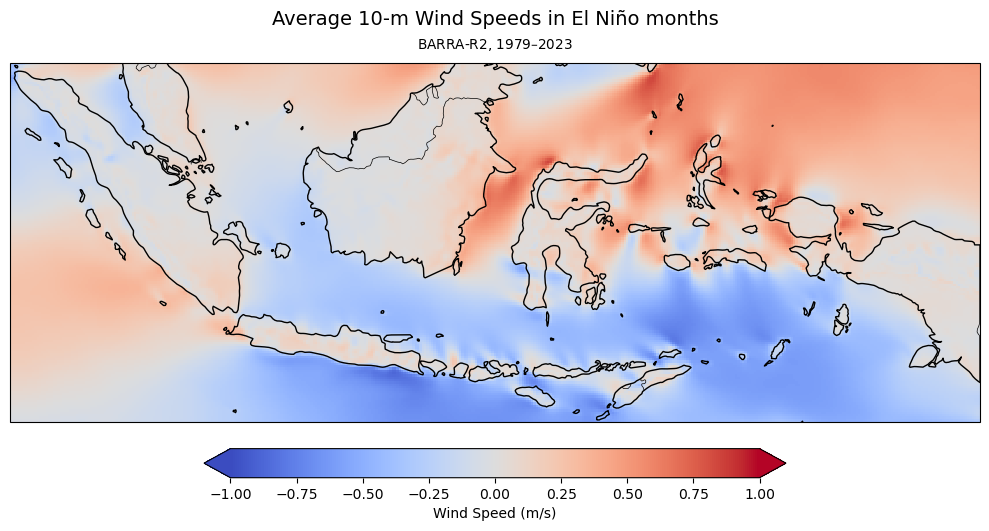

In [299]:
plot_climo('raster', el_nino_winds, 'sfcWind', 'coolwarm', -1, 1, 'both', 'Wind Speed (m/s)', 'Average 10-m Wind Speeds in El Niño months\n$_{\\text{BARRA-R2, 1979–2023}}$')

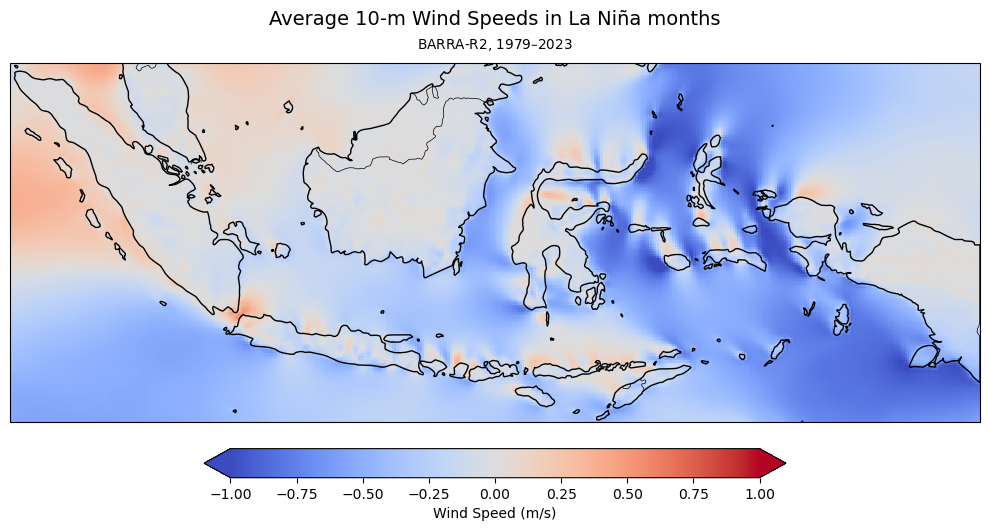

In [302]:
plot_climo('raster', la_nina_winds, 'sfcWind', 'coolwarm', -1, 1, 'both', 'Wind Speed (m/s)', 'Average 10-m Wind Speeds in La Niña months\n$_{\\text{BARRA-R2, 1979–2023}}$')

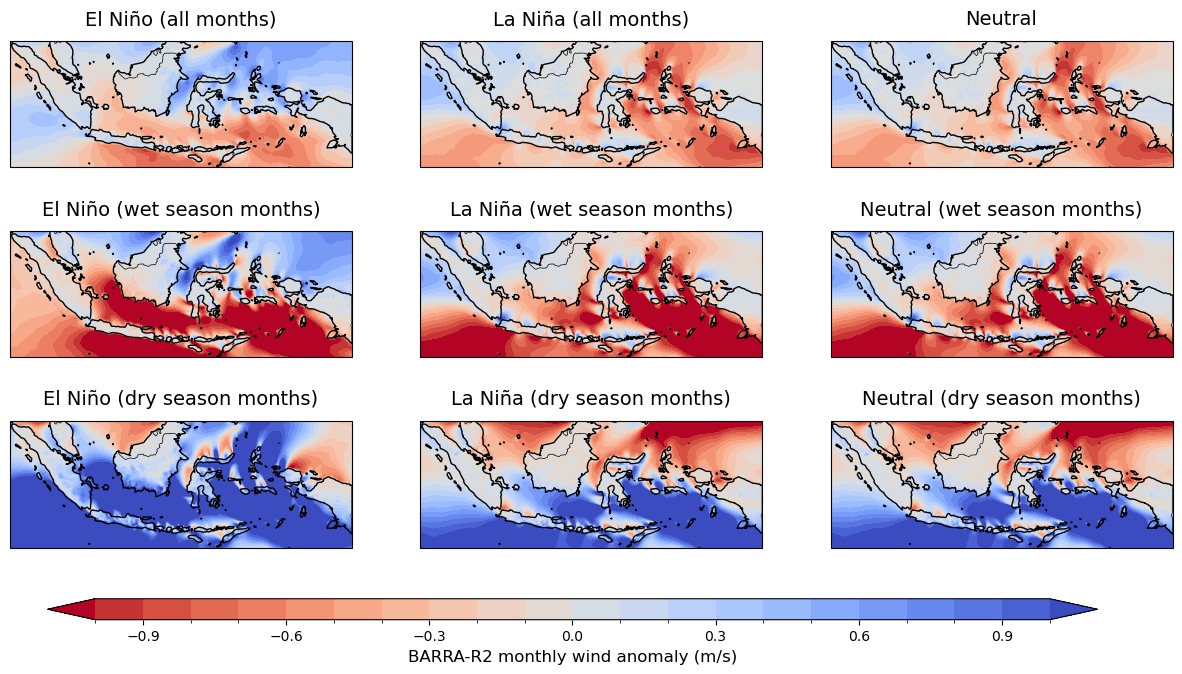

In [326]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(15, 7))
gs = GridSpec(3, 3, figure=fig, hspace=0.2, wspace=0.2)

wind_data_dict = {
    'El Niño (all months)': el_nino_winds['sfcWind'],
    'La Niña (all months)': la_nina_winds['sfcWind'],
    'Neutral': neutral_winds['sfcWind'],
    'El Niño (wet season months)': el_nino_wet_winds['sfcWind'],
    'La Niña (wet season months)': la_nina_wet_winds['sfcWind'],
    'Neutral (wet season months)': neutral_wet_winds['sfcWind'],
    'El Niño (dry season months)': el_nino_dry_winds['sfcWind'],
    'La Niña (dry season months)': la_nina_dry_winds['sfcWind'],
    'Neutral (dry season months)': neutral_dry_winds['sfcWind'],
}

axes = [fig.add_subplot(gs[i], projection=ccrs.PlateCarree()) for i in range(9)]

for ax, (title, wind_data) in zip(axes, wind_data_dict.items()):
    contour = wind_data.plot.contourf(ax=ax, vmin=-1, vmax=1, levels=21, transform=ccrs.PlateCarree(),
                                      cmap='coolwarm_r', add_colorbar=False)
    
    # Customize each subplot
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=14, pad=12)
    ax.set_extent([domain_dict['indonesia']['lon_min'], domain_dict['indonesia']['lon_max'],
                   domain_dict['indonesia']['lat_min'], domain_dict['indonesia']['lat_max']], crs=ccrs.PlateCarree())


cbar_ax = fig.add_axes([0.15, 0.03, 0.7, 0.03])  
cbar = fig.colorbar(contour, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('BARRA-R2 monthly wind anomaly (m/s)', fontsize=12)

# Show the plot
plt.show()